# OCTMNIST Retinal Image Classification

Step1: Loading the dataset and preparing for training

In [1]:
import medmnist
from medmnist import INFO
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support,confusion_matrix, roc_curve, auc
import time
import random
import seaborn as sns
from sklearn.preprocessing import label_binarize

In [2]:

dataset_octmnist = 'octmnist'
info = INFO[dataset_octmnist]
octmnistClass = getattr(medmnist, info['python_class']) 

trainOct = octmnistClass(split='train', download=True)
valOct = octmnistClass(split='val', download=True)

testOct = octmnistClass(split='test', download=True)


In [3]:
trainOct.transform = transforms.ToTensor()
valOct.transform = transforms.ToTensor()
testOct.transform = transforms.ToTensor()


In [4]:
print("Main Statistics For OCTMNIST:")
print("Train images shape:", trainOct.imgs.shape)
print("Validation images shape:", valOct.imgs.shape)
print("Test images shape:", testOct.imgs.shape)

imageLabel, count = np.unique(trainOct.labels, return_counts=True)
print("Class distribution in the training set:")
for u, c in zip(imageLabel, count):
    print(f"Class {u} has {c} samples")

trainImages = np.array([trainOct[i][0].numpy().flatten() for i in range(len(trainOct))])
meanPixelValue = np.mean(trainImages)
stdPixelValue = np.std(trainImages)
print("Pixel Intensity Statistics for Training Set:")
print(f"Mean pixel value: {meanPixelValue:.2f}")
print(f"Standard deviation of pixel values: {stdPixelValue:.2f}")

Main Statistics For OCTMNIST:
Train images shape: (97477, 28, 28)
Validation images shape: (10832, 28, 28)
Test images shape: (1000, 28, 28)
Class distribution in the training set:
Class 0 has 33484 samples
Class 1 has 10213 samples
Class 2 has 7754 samples
Class 3 has 46026 samples
Pixel Intensity Statistics for Training Set:
Mean pixel value: 0.19
Standard deviation of pixel values: 0.20


In [5]:
trainLabels = np.array(trainOct.labels).flatten()
class_counts = np.bincount(trainLabels)
class_weights = 1.0 / (class_counts + 1e-6)
class_weights /= np.sum(class_weights)
classWeights = torch.tensor(class_weights, dtype=torch.float32)
for label, weight in zip(np.unique(trainLabels), classWeights):
    print(f"Class {label} has weight {weight:.2f}")


Class 0 has weight 0.11
Class 1 has weight 0.35
Class 2 has weight 0.46
Class 3 has weight 0.08


In [6]:

trainLoader = DataLoader(trainOct, batch_size=32, shuffle=False)
valLoader = DataLoader(valOct, batch_size=32, shuffle=False)
testLoader = DataLoader(testOct, batch_size=32, shuffle=False)

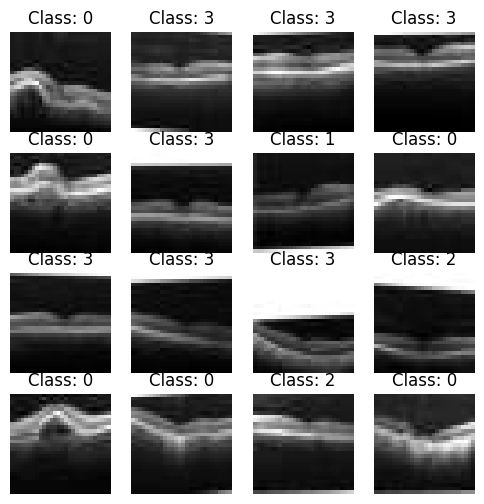

In [7]:
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
axes = axes.ravel()
dataIter = iter(trainLoader)
images, labels = next(dataIter)
for i in range(16):
    axes[i].imshow(images[i].numpy().transpose((1, 2, 0)), cmap='gray')
    axes[i].set_title(f"Class: {labels[i].item()}")
    axes[i].axis('off')
plt.show()


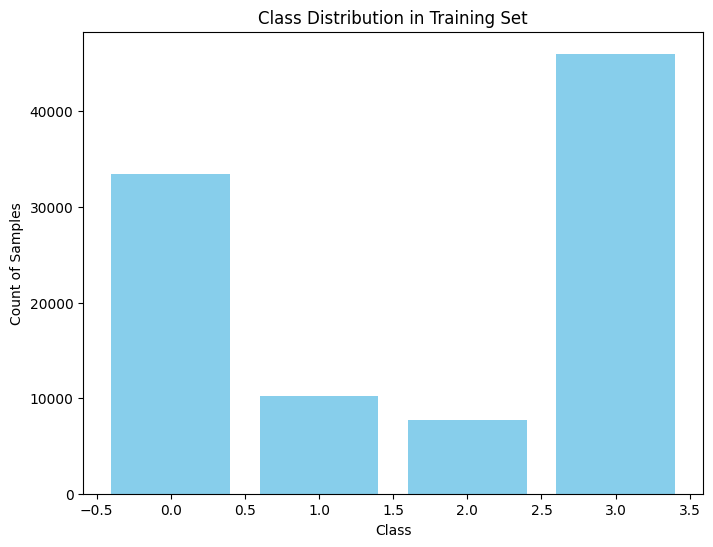

In [8]:
unique, counts = np.unique(trainOct.labels, return_counts=True)
plt.figure(figsize=(8, 6))
plt.bar(unique, counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Count of Samples')
plt.title('Class Distribution in Training Set')
plt.show()


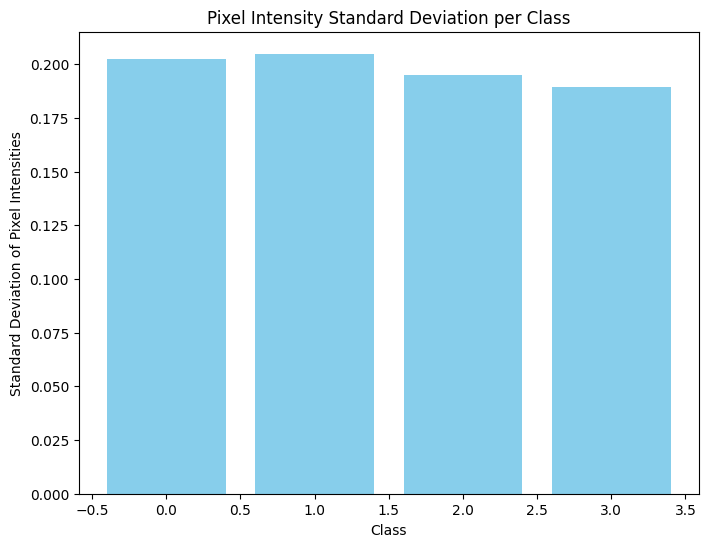

In [9]:
stdDev = []
for c in unique:
    class_images = [trainOct[i][0] for i in range(len(trainOct)) if trainOct[i][1] == c]
    stdDev.append(np.std(np.concatenate([img.numpy().flatten() for img in class_images], axis=0)))

plt.figure(figsize=(8, 6))
plt.bar(unique, stdDev, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Standard Deviation of Pixel Intensities')
plt.title('Pixel Intensity Standard Deviation per Class')
plt.show()


Step 2: Defining the Neural Network

In [10]:
class OctMNISTModel(nn.Module):
    def __init__(self):
        super(OctMNISTModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 4)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.output(x)
        return x

octmodel = OctMNISTModel()


In [11]:
summary(octmodel, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
OctMNISTModel                            [1, 4]                    --
├─Conv2d: 1-1                            [1, 32, 28, 28]           320
├─MaxPool2d: 1-2                         [1, 32, 14, 14]           --
├─Conv2d: 1-3                            [1, 64, 14, 14]           18,496
├─MaxPool2d: 1-4                         [1, 64, 7, 7]             --
├─Linear: 1-5                            [1, 128]                  401,536
├─Dropout: 1-6                           [1, 128]                  --
├─Linear: 1-7                            [1, 64]                   8,256
├─Dropout: 1-8                           [1, 64]                   --
├─Linear: 1-9                            [1, 4]                    260
Total params: 428,868
Trainable params: 428,868
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 4.29
Input size (MB): 0.00
Forward/backward pass size (MB): 0.30
Params size (MB): 1.72
Estimated Total 

Step 3: Training the Neural Network

In [12]:
lossFunction = nn.CrossEntropyLoss(weight=classWeights)

In [13]:
optimizer = optim.SGD(octmodel.parameters(), lr=0.003, momentum=0.9)

In [14]:

def trainValidate(model, trainLoader, valLoader, lossFunction, optimizer, numepochs):
    startTime = time.time()

    trainLosses = []
    valLosses = []
    trainAccuracies = []
    valAccuracies = []
    
    for epoch in range(numepochs):
        model.train()
        runningLoss = 0.0
        correctTrain = 0
        totalTrain = 0
        
        for inputs, labels in trainLoader:
            labels = labels.squeeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = lossFunction(outputs, labels)
            runningLoss += loss.item()
            
            predictedLabels = torch.max(outputs, 1)[1]
            correctTrain += (predictedLabels == labels).sum().item()
            totalTrain += labels.size(0)
            
            loss.backward()
            optimizer.step()
        
        avgTrainLoss = runningLoss / len(trainLoader)
        trainAccuracy = correctTrain / totalTrain
        
        trainLosses.append(avgTrainLoss)
        trainAccuracies.append(trainAccuracy)

        print(f"Epoch [{epoch+1}/{numepochs}] has Training Loss: {avgTrainLoss:.4f}, Training Accuracy: {trainAccuracy*100:.4f}%")
        
        model.eval()
        valLoss = 0.0
        correctVal = 0
        totalVal = 0
        
        with torch.no_grad():
            for valinputs, vallabels in valLoader:
                vallabels = vallabels.squeeze(1)
                valoutputs = model(valinputs)
                vloss = lossFunction(valoutputs, vallabels)
                valLoss += vloss.item()
                
                predictedValLabels = torch.max(valoutputs, 1)[1]
                correctVal += (predictedValLabels == vallabels).sum().item()
                totalVal += vallabels.size(0)
        
        avgValLoss = valLoss / len(valLoader)
        valAccuracy = correctVal / totalVal
        
        valLosses.append(avgValLoss)
        valAccuracies.append(valAccuracy)

        print(f"Epoch [{epoch+1}/{numepochs}] has Validation Loss: {avgValLoss:.4f}, Validation Accuracy: {valAccuracy*100:.4f}%")
    
    elapsedTime = time.time() - startTime
    print(f"Training completed in {elapsedTime} seconds")
    
    return trainLosses, valLosses, trainAccuracies, valAccuracies


In [15]:
numepochs = 18
trainingLosses, validationLosses, trainingAccuracies, validationAccuracies = trainValidate(octmodel, trainLoader, valLoader, lossFunction, optimizer, numepochs)

Epoch [1/18] has Training Loss: 1.3744, Training Accuracy: 42.8809%
Epoch [1/18] has Validation Loss: 1.3239, Validation Accuracy: 54.9114%
Epoch [2/18] has Training Loss: 1.1695, Training Accuracy: 61.0759%
Epoch [2/18] has Validation Loss: 0.9559, Validation Accuracy: 68.3438%
Epoch [3/18] has Training Loss: 0.8620, Training Accuracy: 70.0073%
Epoch [3/18] has Validation Loss: 0.6879, Validation Accuracy: 75.3508%
Epoch [4/18] has Training Loss: 0.7342, Training Accuracy: 73.1824%
Epoch [4/18] has Validation Loss: 0.6575, Validation Accuracy: 72.4705%
Epoch [5/18] has Training Loss: 0.6691, Training Accuracy: 75.3019%
Epoch [5/18] has Validation Loss: 0.6246, Validation Accuracy: 76.8648%
Epoch [6/18] has Training Loss: 0.6272, Training Accuracy: 76.6591%
Epoch [6/18] has Validation Loss: 0.5773, Validation Accuracy: 82.6994%
Epoch [7/18] has Training Loss: 0.5935, Training Accuracy: 78.1292%
Epoch [7/18] has Validation Loss: 0.5857, Validation Accuracy: 77.5295%
Epoch [8/18] has Tra

In [16]:
def testModel(model, testLoader, lossFunction):
    model.eval()
    testLoss = 0.0
    correctTest = 0
    totalTest = 0
    allPredictedlabels = []
    allLabels = []
    allOutputs = []
    
    with torch.no_grad():
        for testInputs, testLabels in testLoader:
            testLabels = testLabels.squeeze(1)
            testOutputs = model(testInputs)
            outputs = testOutputs
            yTrue = testLabels.cpu().numpy()
            yPred = torch.max(testOutputs, 1)[1].cpu().numpy()
            
            allOutputs.extend(outputs.cpu().numpy())
            allPredictedlabels.extend(yPred)
            allLabels.extend(yTrue)
            
            tLoss = lossFunction(testOutputs, testLabels)
            testLoss += tLoss.item()
            
            predictedTestLabels = torch.max(testOutputs, 1)[1]
            correctTest += (predictedTestLabels == testLabels).sum().item()
            totalTest += testLabels.size(0)
    
    avgTestLoss = testLoss / len(testLoader)
    testAccuracy = correctTest / totalTest
    
    precision, recall, f1, _ = precision_recall_fscore_support(allLabels, allPredictedlabels, average='macro')
    
    print(f"Test Loss: {avgTestLoss:.4f}")
    print(f"Test Accuracy: {testAccuracy*100:.4f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return avgTestLoss, testAccuracy, precision, recall, f1, allOutputs, allLabels, allPredictedlabels


In [17]:
testingLoss, testingAccuracy, precision, recall, f1,testingOutputs, testingLabels, testingPredictedlabels =testModel(octmodel, testLoader, lossFunction)

Test Loss: 0.9958
Test Accuracy: 75.5000%
Precision: 0.7662
Recall: 0.7550
F1 Score: 0.7497


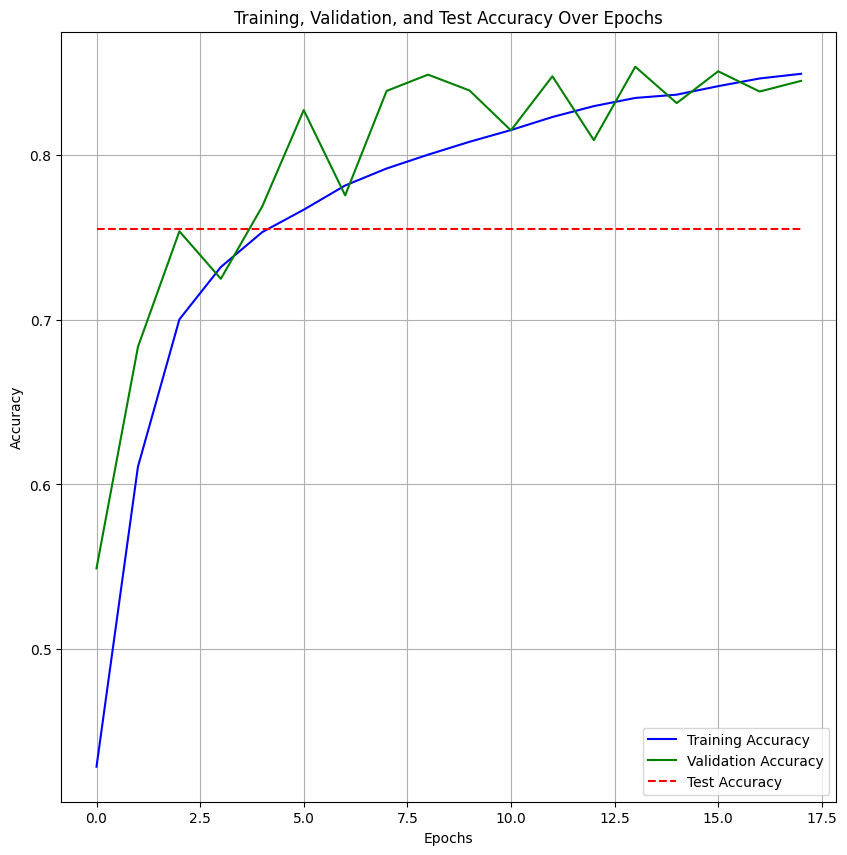

In [19]:

plt.figure(figsize=(10, 10))
plt.plot(range(numepochs), trainingAccuracies, label='Training Accuracy', color='blue')
plt.plot(range(numepochs), validationAccuracies, label='Validation Accuracy', color='green')
testingAccuracyLine = [testingAccuracy] * numepochs
plt.plot(range(numepochs), testingAccuracyLine, label='Test Accuracy', color='red', linestyle='--')
plt.title('Training, Validation, and Test Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


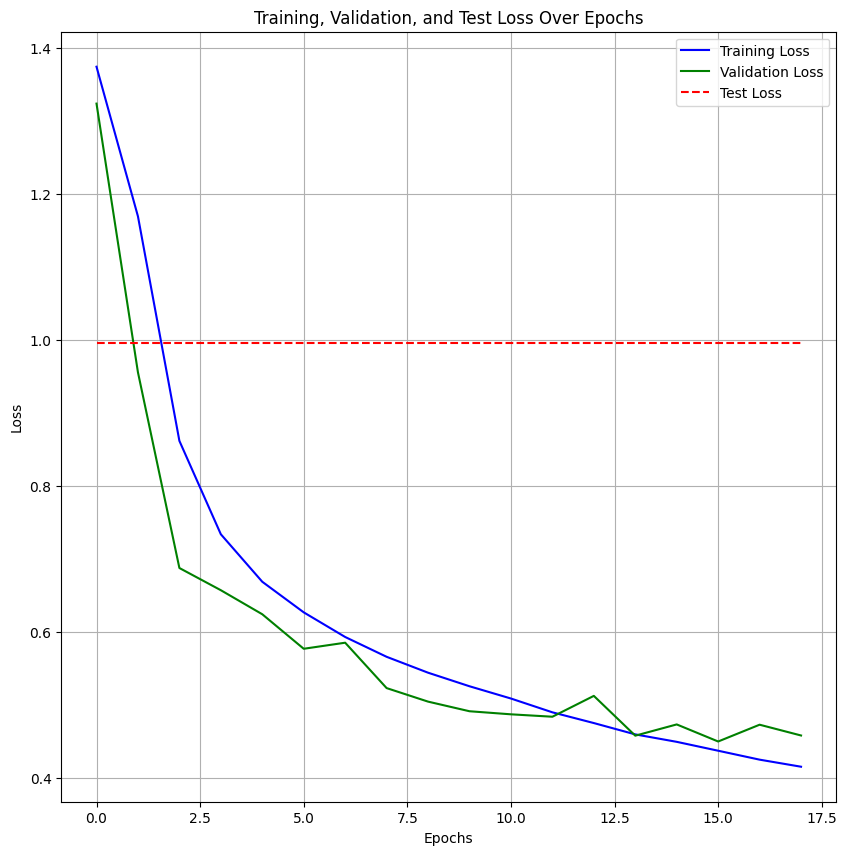

In [20]:
plt.figure(figsize=(10, 10))
plt.plot(range(numepochs), trainingLosses, label='Training Loss', color='blue')
plt.plot(range(numepochs), validationLosses, label='Validation Loss', color='green')
testingLossLine = [testingLoss] * numepochs
plt.plot(range(numepochs), testingLossLine, label='Test Loss', color='red', linestyle='--')
plt.title('Training, Validation, and Test Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

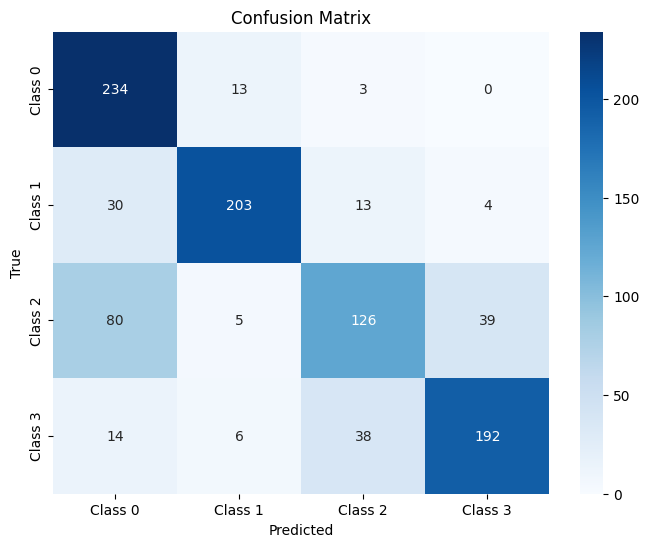

In [21]:
cm = confusion_matrix(testingLabels, testingPredictedlabels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], 
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


/var/folders/y1/4ydmkr1n7f72dsyswnh_jqwc0000gn/T/ipykernel_8296/824254615.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  outputs = torch.tensor(testingOutputs)


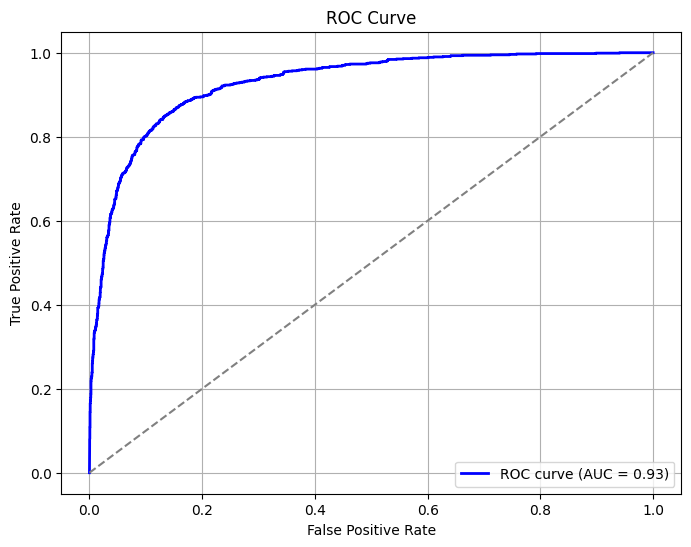

In [22]:
testingLabelsBin = label_binarize(testingLabels, classes=[0, 1, 2, 3])
outputs = torch.tensor(testingOutputs)
probabilities = torch.softmax(outputs, dim=1).detach().numpy()

falsePositiveRate, truePositiveRate, thresholds = roc_curve(testingLabelsBin.ravel(), probabilities.ravel())
rocAuc = auc(falsePositiveRate, truePositiveRate)

plt.figure(figsize=(8, 6))
plt.plot(falsePositiveRate, truePositiveRate, color='blue', lw=2, label=f'ROC curve (AUC = {rocAuc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [30]:
octmodelMM=OctMNISTModel()

In [34]:
lossFunctionMM = nn.MultiMarginLoss(weight=classWeights,margin=10,p=2)
trainingLossesMM, validationLossesMM, trainingAccuraciesMM, validationAccuraciesMM = trainValidate(octmodelMM, trainLoader, valLoader, lossFunctionMM, optimizer,numepochs)
testingLossMM, testingAccuracyMM, precisionMM, recallMM, f1MM, testingOutputsMM, testingLabelsMM, testingPredictedlabelsMM = testModel(octmodelMM, testLoader, lossFunctionMM)

Epoch [1/18] has Training Loss: 11.0516, Training Accuracy: 30.1969%
Epoch [1/18] has Validation Loss: 11.0504, Validation Accuracy: 46.3349%
Epoch [2/18] has Training Loss: 11.0514, Training Accuracy: 30.2030%
Epoch [2/18] has Validation Loss: 11.0504, Validation Accuracy: 46.3349%
Epoch [3/18] has Training Loss: 11.0513, Training Accuracy: 30.3436%
Epoch [3/18] has Validation Loss: 11.0504, Validation Accuracy: 46.3349%
Epoch [4/18] has Training Loss: 11.0516, Training Accuracy: 30.2430%
Epoch [4/18] has Validation Loss: 11.0504, Validation Accuracy: 46.3349%
Epoch [5/18] has Training Loss: 11.0516, Training Accuracy: 30.1086%
Epoch [5/18] has Validation Loss: 11.0504, Validation Accuracy: 46.3349%
Epoch [6/18] has Training Loss: 11.0517, Training Accuracy: 29.9948%
Epoch [6/18] has Validation Loss: 11.0504, Validation Accuracy: 46.3349%
Epoch [7/18] has Training Loss: 11.0514, Training Accuracy: 30.1435%
Epoch [7/18] has Validation Loss: 11.0504, Validation Accuracy: 46.3349%
Epoch 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


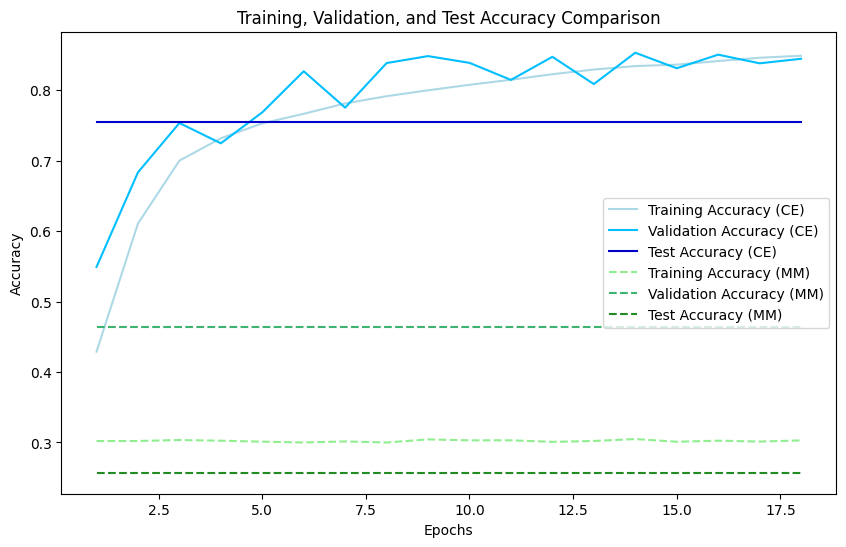

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, numepochs+1), trainingAccuracies, label='Training Accuracy (CE)', color='lightblue')
plt.plot(range(1, numepochs+1), validationAccuracies, label='Validation Accuracy (CE)', color='deepskyblue')
plt.plot(range(1, numepochs+1), [testingAccuracy]*numepochs, label='Test Accuracy (CE)', color='mediumblue')
plt.plot(range(1, numepochs+1), trainingAccuraciesMM, label='Training Accuracy (MM)', color='lightgreen', linestyle='--')
plt.plot(range(1, numepochs+1), validationAccuraciesMM, label='Validation Accuracy (MM)', color='mediumseagreen', linestyle='--')
plt.plot(range(1, numepochs+1), [testingAccuracyMM]*numepochs, label='Test Accuracy (MM)', color='forestgreen', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Validation, and Test Accuracy Comparison')
plt.legend()
plt.show()

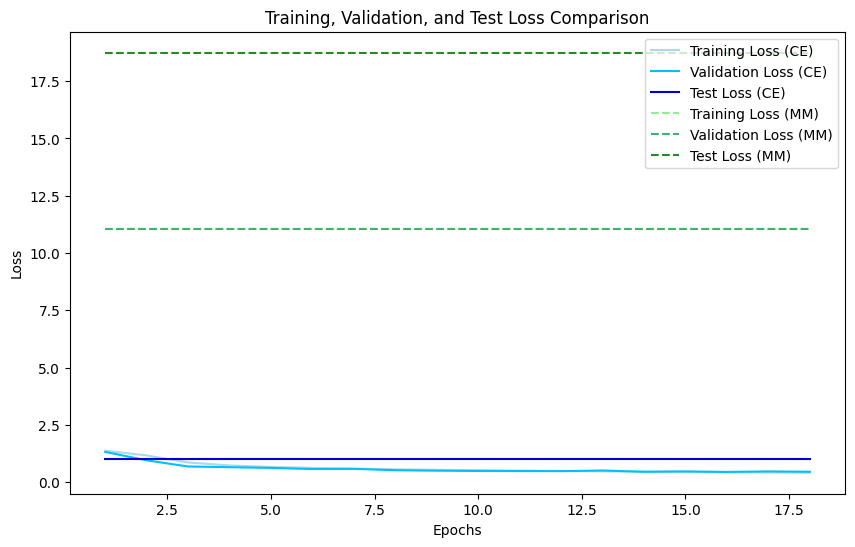

In [36]:


plt.figure(figsize=(10, 6))
plt.plot(range(1, numepochs+1), trainingLosses, label='Training Loss (CE)', color='lightblue')
plt.plot(range(1, numepochs+1), validationLosses, label='Validation Loss (CE)', color='deepskyblue')
plt.plot(range(1, numepochs+1), [testingLoss]*numepochs, label='Test Loss (CE)', color='mediumblue')
plt.plot(range(1, numepochs+1), trainingLossesMM, label='Training Loss (MM)', color='lightgreen', linestyle='--')
plt.plot(range(1, numepochs+1), validationLossesMM, label='Validation Loss (MM)', color='mediumseagreen', linestyle='--')
plt.plot(range(1, numepochs+1), [testingLossMM]*numepochs, label='Test Loss (MM)', color='forestgreen', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss Comparison')
plt.legend()
plt.show()

LearningRateScheduler

In [160]:
from torch.optim.lr_scheduler import StepLR

No changes in model structure

In [161]:
octModelLR = OctMNISTModel() 
optimizerLR = torch.optim.SGD(octModelLR.parameters(), lr=0.01, momentum=0.9)
schedulerLR = StepLR(optimizer, step_size=1, gamma=0.5)

Changes while training for LR Scheduler

In [162]:
def trainValidateLR(model, trainLoader, valLoader, lossFunction, optimizer, scheduler, numepochs):
    startTime = time.time()

    trainLosses = []
    valLosses = []
    trainAccuracies = []
    valAccuracies = []
    
    for epoch in range(numepochs):
        model.train()
        runningLoss = 0.0
        correctTrain = 0
        totalTrain = 0
        
        for inputs, labels in trainLoader:
            labels = labels.squeeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = lossFunction(outputs, labels)
            runningLoss += loss.item()
            
            predictedLabels = torch.max(outputs, 1)[1]
            correctTrain += (predictedLabels == labels).sum().item()
            totalTrain += labels.size(0)
            
            loss.backward()
            optimizer.step()

        scheduler.step()
        
        avgTrainLoss = runningLoss / len(trainLoader)
        trainAccuracy = correctTrain / totalTrain
        
        trainLosses.append(avgTrainLoss)
        trainAccuracies.append(trainAccuracy)

        print(f"Epoch [{epoch+1}/{numepochs}] has Training Loss: {avgTrainLoss:.4f}, Training Accuracy: {trainAccuracy*100:.4f}%")
        
        model.eval()
        valLoss = 0.0
        correctVal = 0
        totalVal = 0
        
        with torch.no_grad():
            for valinputs, vallabels in valLoader:
                vallabels = vallabels.squeeze(1)
                valoutputs = model(valinputs)
                vloss = lossFunction(valoutputs, vallabels)
                valLoss += vloss.item()
                
                predictedValLabels = torch.max(valoutputs, 1)[1]
                correctVal += (predictedValLabels == vallabels).sum().item()
                totalVal += vallabels.size(0)
        
        avgValLoss = valLoss / len(valLoader)
        valAccuracy = correctVal / totalVal
        
        valLosses.append(avgValLoss)
        valAccuracies.append(valAccuracy)

        print(f"Epoch [{epoch+1}/{numepochs}] has Validation Loss: {avgValLoss:.4f}, Validation Accuracy: {valAccuracy*100:.4f}%")
        print(f"Learning Rate after Epoch {epoch+1}: {scheduler.get_last_lr()}")

    elapsedTime = time.time() - startTime
    print(f"Training completed in {elapsedTime} seconds")
    
    return trainLosses, valLosses, trainAccuracies, valAccuracies


In [163]:
trainingLossesLR, validationLossesLR, trainingAccuraciesLR, validationAccuraciesLR = trainValidateLR(octModelLR, trainLoader, valLoader, lossFunction, optimizerLR,schedulerLR,25)

Epoch [1/25] has Training Loss: 1.2820, Training Accuracy: 49.2198%
Epoch [1/25] has Validation Loss: 0.9414, Validation Accuracy: 71.7596%
Learning Rate after Epoch 1: [7.432527981876548e-20]
Epoch [2/25] has Training Loss: 0.8576, Training Accuracy: 69.1291%
Epoch [2/25] has Validation Loss: 0.7541, Validation Accuracy: 64.6603%
Learning Rate after Epoch 2: [3.716263990938274e-20]
Epoch [3/25] has Training Loss: 0.7178, Training Accuracy: 73.1013%
Epoch [3/25] has Validation Loss: 0.6111, Validation Accuracy: 75.9694%
Learning Rate after Epoch 3: [1.858131995469137e-20]
Epoch [4/25] has Training Loss: 0.6647, Training Accuracy: 75.2383%
Epoch [4/25] has Validation Loss: 0.5910, Validation Accuracy: 79.0066%
Learning Rate after Epoch 4: [9.290659977345684e-21]
Epoch [5/25] has Training Loss: 0.6279, Training Accuracy: 77.6009%
Epoch [5/25] has Validation Loss: 0.5732, Validation Accuracy: 83.8165%
Learning Rate after Epoch 5: [4.645329988672842e-21]
Epoch [6/25] has Training Loss: 0.6

No changes in testing phase.

In [164]:
testingLossLR, testingAccuracyLR, precisionLR, recallLR, f1LR,testingOutputsLR, testingLabelsLR, testingPredictedlabelsLR =testModel(octModelLR, testLoader, lossFunction)

Test Loss: 1.2827
Test Accuracy: 74.0000%
Precision: 0.7763
Recall: 0.7400
F1 Score: 0.7279


Batch Normalization

Changes in model structure

In [191]:


class OctMNISTModelBN(nn.Module):
    def __init__(self):
        super(OctMNISTModelBN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.bn3 = nn.BatchNorm1d(128)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        
        self.output = nn.Linear(64, 4)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn3(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn4(self.fc2(x)))
        x = self.dropout(x)
        x = self.output(x)
        return x


In [192]:
octModelBN = OctMNISTModelBN()

No changes in training

In [193]:
optimizerBN = optim.SGD(octModelBN.parameters(), lr=0.003 , momentum=0.9)
trainingLossesBN, validationLossesBN, trainingAccuraciesBN, validationAccuraciesBN = trainValidate(octModelBN, trainLoader, valLoader, lossFunction, optimizerBN,10)

Epoch [1/10] has Training Loss: 0.9326, Training Accuracy: 64.9958%
Epoch [1/10] has Validation Loss: 0.7631, Validation Accuracy: 65.9343%
Epoch [2/10] has Training Loss: 0.7023, Training Accuracy: 74.4463%
Epoch [2/10] has Validation Loss: 0.6989, Validation Accuracy: 69.6455%
Epoch [3/10] has Training Loss: 0.6404, Training Accuracy: 76.8345%
Epoch [3/10] has Validation Loss: 0.5335, Validation Accuracy: 78.5543%
Epoch [4/10] has Training Loss: 0.5943, Training Accuracy: 78.8145%
Epoch [4/10] has Validation Loss: 0.4971, Validation Accuracy: 81.2131%
Epoch [5/10] has Training Loss: 0.5616, Training Accuracy: 80.1204%
Epoch [5/10] has Validation Loss: 0.4781, Validation Accuracy: 81.8870%
Epoch [6/10] has Training Loss: 0.5337, Training Accuracy: 81.3751%
Epoch [6/10] has Validation Loss: 0.4876, Validation Accuracy: 84.1211%
Epoch [7/10] has Training Loss: 0.5070, Training Accuracy: 82.2615%
Epoch [7/10] has Validation Loss: 0.4389, Validation Accuracy: 84.0750%
Epoch [8/10] has Tra

No changes in testing

In [194]:
testingLossBN, testingAccuracyBN, precisionBN, recallBN, f1BN,testingOutputsBN, testingLabelsBN, testingPredictedlabelsBN =testModel(octModelBN, testLoader, lossFunction)

Test Loss: 0.8016
Test Accuracy: 76.6000%
Precision: 0.7774
Recall: 0.7660
F1 Score: 0.7579


kfold

No change in model architecture

In [169]:
octmodelkfold = OctMNISTModel()

Changes in training

In [170]:
from torch.utils.data import Subset, ConcatDataset
from sklearn.model_selection import KFold

In [171]:
def trainValidateKFold(modelClass, trainOct, valOct, lossFunction, optimizer, numepochs, k):
    combinedDataset = ConcatDataset([trainOct, valOct])
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    
    foldResults = {'trainLosses': [], 'valLosses': [], 'trainAccuracies': [], 'valAccuracies': []}

    for fold, (train_idx, val_idx) in enumerate(kfold.split(combinedDataset)):
        print(f"\nFold {fold+1}/{k}")
        trainSubset = Subset(combinedDataset, train_idx)
        valSubset = Subset(combinedDataset, val_idx)

        trainLoader = DataLoader(trainSubset, batch_size=32, shuffle=True)
        valLoader = DataLoader(valSubset, batch_size=32, shuffle=False)

        model = modelClass()

        startTime = time.time()

        trainLosses = []
        valLosses = []
        trainAccuracies = []
        valAccuracies = []

        for epoch in range(numepochs):
            model.train()
            runningLoss = 0.0
            correctTrain = 0
            totalTrain = 0

            for inputs, labels in trainLoader:
                labels = labels.squeeze(1)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = lossFunction(outputs, labels)
                runningLoss += loss.item()

                predictedLabels = torch.max(outputs, 1)[1]
                correctTrain += (predictedLabels == labels).sum().item()
                totalTrain += labels.size(0)

                loss.backward()
                optimizer.step()

            avgTrainLoss = runningLoss / len(trainLoader)
            trainAccuracy = correctTrain / totalTrain

            trainLosses.append(avgTrainLoss)
            trainAccuracies.append(trainAccuracy)

            print(f"Epoch [{epoch+1}/{numepochs}] has Training Loss: {avgTrainLoss:.4f}, Training Accuracy: {trainAccuracy*100:.4f}%")

            model.eval()
            valLoss = 0.0
            correctVal = 0
            totalVal = 0

            with torch.no_grad():
                for valinputs, vallabels in valLoader:
                    vallabels = vallabels.squeeze(1)
                    valoutputs = model(valinputs)
                    vloss = lossFunction(valoutputs, vallabels)
                    valLoss += vloss.item()

                    predictedValLabels = torch.max(valoutputs, 1)[1]
                    correctVal += (predictedValLabels == vallabels).sum().item()
                    totalVal += vallabels.size(0)

            avgValLoss = valLoss / len(valLoader)
            valAccuracy = correctVal / totalVal

            valLosses.append(avgValLoss)
            valAccuracies.append(valAccuracy)

            print(f"Epoch [{epoch+1}/{numepochs}] has Validation Loss: {avgValLoss:.4f}, Validation Accuracy: {valAccuracy*100:.4f}%")

        elapsedTime = time.time() - startTime
        print(f"Training completed in {elapsedTime} seconds")

        foldResults['trainLosses'].extend(trainLosses)
        foldResults['valLosses'].extend(valLosses)
        foldResults['trainAccuracies'].extend(trainAccuracies)
        foldResults['valAccuracies'].extend(valAccuracies)

    return foldResults


In [172]:
optimizerkf = optim.SGD(octmodelkfold.parameters(), lr=0.003, momentum=0.9 )

In [173]:
foldResults = trainValidateKFold(OctMNISTModel, trainOct, valOct, lossFunction, optimizerkf, 5, 3)

trainingLosseskf = foldResults['trainLosses']
validationLosseskf = foldResults['valLosses']
trainingAccuracieskf = foldResults['trainAccuracies']
validationAccuracieskf = foldResults['valAccuracies']



Fold 1/3
Epoch [1/5] has Training Loss: 1.3862, Training Accuracy: 46.4864%
Epoch [1/5] has Validation Loss: 1.3863, Validation Accuracy: 46.8908%
Epoch [2/5] has Training Loss: 1.3864, Training Accuracy: 46.5682%
Epoch [2/5] has Validation Loss: 1.3863, Validation Accuracy: 46.8908%
Epoch [3/5] has Training Loss: 1.3865, Training Accuracy: 46.5474%
Epoch [3/5] has Validation Loss: 1.3863, Validation Accuracy: 46.8908%
Epoch [4/5] has Training Loss: 1.3864, Training Accuracy: 46.5183%
Epoch [4/5] has Validation Loss: 1.3863, Validation Accuracy: 46.8908%
Epoch [5/5] has Training Loss: 1.3863, Training Accuracy: 46.4948%
Epoch [5/5] has Validation Loss: 1.3863, Validation Accuracy: 46.8908%
Training completed in 98.42600512504578 seconds

Fold 2/3
Epoch [1/5] has Training Loss: 1.3862, Training Accuracy: 43.6653%
Epoch [1/5] has Validation Loss: 1.3861, Validation Accuracy: 47.3894%
Epoch [2/5] has Training Loss: 1.3865, Training Accuracy: 43.5282%
Epoch [2/5] has Validation Loss: 1.38

In [174]:
testingLosskf, testingAccuracykf, precisionkf, recallkf, f1kf,testingOutputskf, testingLabelskf, testingPredictedlabelskf =testModel(octmodelkfold, testLoader, lossFunction)

Test Loss: 1.4177
Test Accuracy: 25.0000%
Precision: 0.0625
Recall: 0.2500
F1 Score: 0.1000


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Data Augmentation

In [175]:
from torch.utils.data import Dataset

In [176]:
augmentationTransforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.RandomVerticalFlip()
])

augmentedImages = []
augmentedLabels = []

for image, label in trainOct:
    if label in [1, 2]:
        for _ in range(5):
            augmentedImages.append(augmentationTransforms(image))
            augmentedLabels.append(label)

class AugmentedDataset(Dataset):
    def __init__(self, originalDataset, augmentedImages, augmentedLabels):
        self.originalDataset = originalDataset
        self.augmentedImages = augmentedImages
        self.augmentedLabels = augmentedLabels
        
    def __len__(self):
        return len(self.originalDataset) + len(self.augmentedImages)
    
    def __getitem__(self, idx):
        if idx < len(self.originalDataset):
            return self.originalDataset[idx]
        else:
            augIdx = idx - len(self.originalDataset)
            return self.augmentedImages[augIdx], self.augmentedLabels[augIdx]

augmentedTrainOct = AugmentedDataset(trainOct, augmentedImages, augmentedLabels)

trainAugmentedLoader = DataLoader(augmentedTrainOct, batch_size=32, shuffle=True)

allLabels = [label for _, label in trainOct] + augmentedLabels
uniqueLabels, counts = np.unique(allLabels, return_counts=True)

for label, count in zip(uniqueLabels, counts):
    print(f"Class {label} has {count} samples")


Class 0 has 33484 samples
Class 1 has 61278 samples
Class 2 has 46524 samples
Class 3 has 46026 samples


No change in model structure

In [177]:
octmodelDa = OctMNISTModel()

Changes in training

In [178]:
optimizerda = optim.SGD(octmodelDa.parameters(), lr=0.01, momentum=0.8, weight_decay=1e-3)
randomWeights = 0.25 + (0.75 - 0.25) * torch.rand(4)
lossFunctionda = nn.CrossEntropyLoss(weight=randomWeights)
trainingLossesda, validationLossesda, trainingAccuraciesda, validationAccuraciesda = trainValidate(octmodelDa, trainAugmentedLoader, valLoader, lossFunctionda, optimizerda,10)

Epoch [1/10] has Training Loss: 0.8396, Training Accuracy: 57.0887%
Epoch [1/10] has Validation Loss: 0.6170, Validation Accuracy: 78.9974%
Epoch [2/10] has Training Loss: 0.5676, Training Accuracy: 71.9484%
Epoch [2/10] has Validation Loss: 0.4557, Validation Accuracy: 83.3087%
Epoch [3/10] has Training Loss: 0.4758, Training Accuracy: 78.3377%
Epoch [3/10] has Validation Loss: 0.4207, Validation Accuracy: 84.9982%
Epoch [4/10] has Training Loss: 0.4425, Training Accuracy: 80.3771%
Epoch [4/10] has Validation Loss: 0.3870, Validation Accuracy: 85.0443%
Epoch [5/10] has Training Loss: 0.4225, Training Accuracy: 81.2617%
Epoch [5/10] has Validation Loss: 0.3963, Validation Accuracy: 85.5705%
Epoch [6/10] has Training Loss: 0.4087, Training Accuracy: 81.9921%
Epoch [6/10] has Validation Loss: 0.3743, Validation Accuracy: 85.4228%
Epoch [7/10] has Training Loss: 0.3997, Training Accuracy: 82.4160%
Epoch [7/10] has Validation Loss: 0.3713, Validation Accuracy: 87.0476%
Epoch [8/10] has Tra

No changes in testing

In [179]:
testingLossda, testingAccuracyda, precisionda, recallda, f1da,testingOutputsda, testingLabelsda, testingPredictedlabelsda =testModel(octmodelDa, testLoader, lossFunctionda)

Test Loss: 0.7069
Test Accuracy: 68.2000%
Precision: 0.7308
Recall: 0.6820
F1 Score: 0.5956


The best accuracy is obtained by BATCH NORMALIZATION 

Graphs and Performance metrices of best model

Test Loss: 0.8016
Test Accuracy: 76.6000%
Precision: 0.7774
Recall: 0.7660
F1 Score: 0.7579


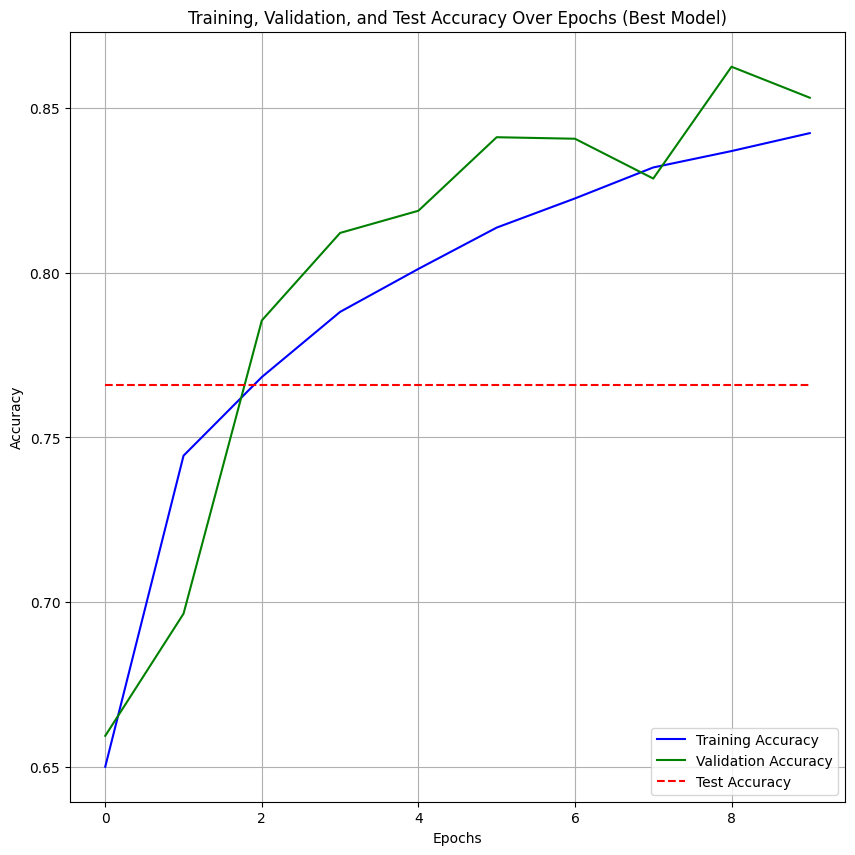

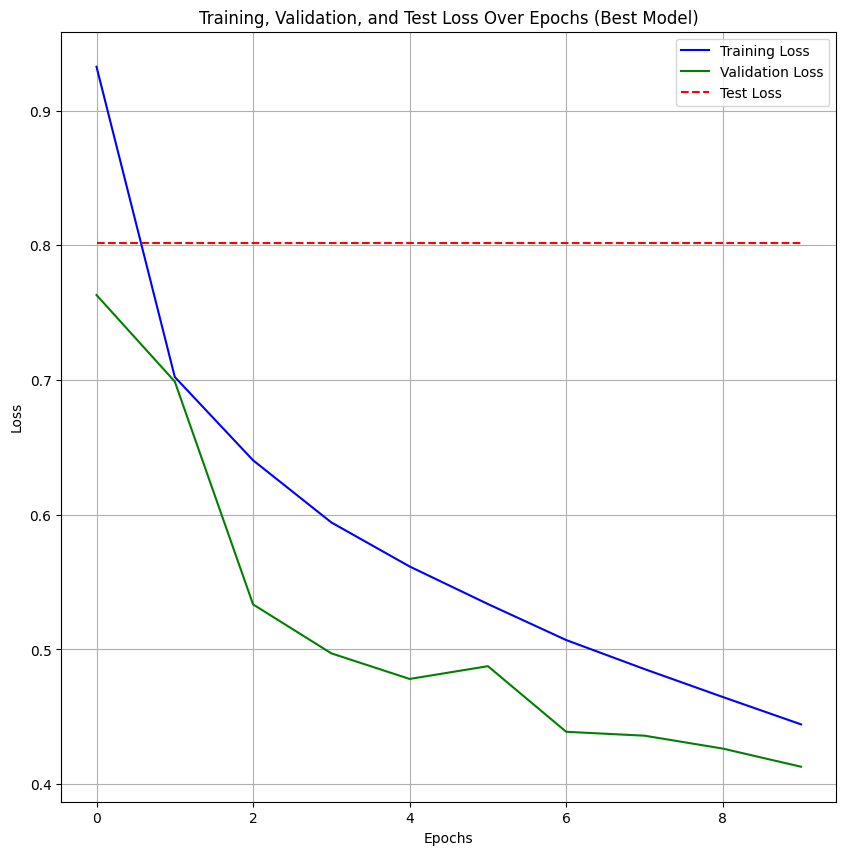

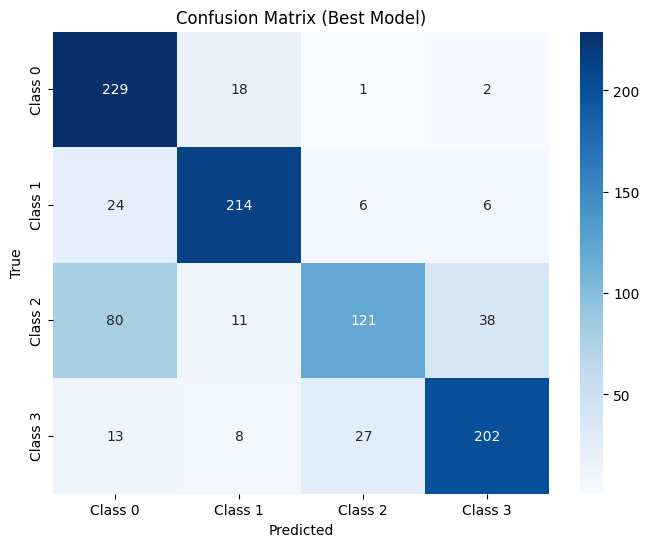

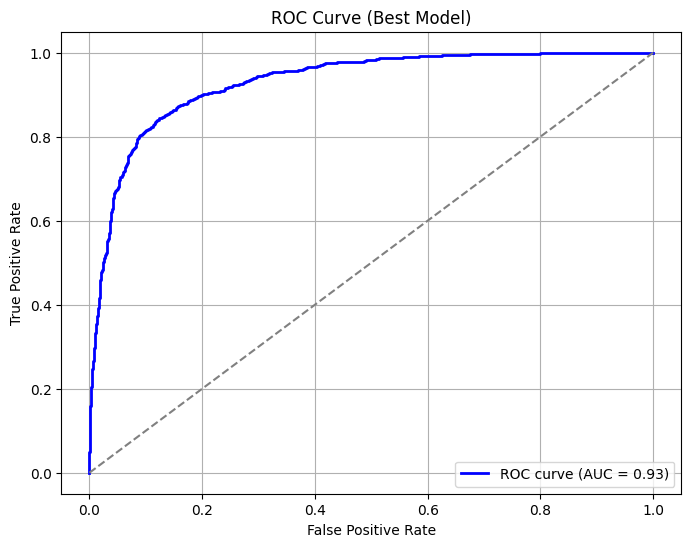

In [198]:
testingLossBestModel = testingLossBN
testingAccuracyBestModel = testingAccuracyBN
precisionBestModel = precisionBN
recallBestModel = recallBN
f1BestModel = f1BN
testingOutputsBestModel = testingOutputsBN
testingLabelsBestModel = testingLabelsBN
testingPredictedlabelsBestModel = testingPredictedlabelsBN
trainingAccuraciesBestModel = trainingAccuraciesBN
validationAccuraciesBestModel = validationAccuraciesBN
trainingLossesBestModel = trainingLossesBN
validationLossesBestModel = validationLossesBN

print(f"Test Loss: {testingLossBestModel:.4f}")
print(f"Test Accuracy: {testingAccuracyBestModel*100:.4f}%")
print(f"Precision: {precisionBestModel:.4f}")
print(f"Recall: {recallBestModel:.4f}")
print(f"F1 Score: {f1BestModel:.4f}")

plt.figure(figsize=(10, 10))
plt.plot(range(10), trainingAccuraciesBestModel, label='Training Accuracy', color='blue')
plt.plot(range(10), validationAccuraciesBestModel, label='Validation Accuracy', color='green')
testingAccuracyLineBestModel = [testingAccuracyBestModel] * 10
plt.plot(range(10), testingAccuracyLineBestModel, label='Test Accuracy', color='red', linestyle='--')
plt.title('Training, Validation, and Test Accuracy Over Epochs (Best Model)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 10))
plt.plot(range(10), trainingLossesBestModel, label='Training Loss', color='blue')
plt.plot(range(10), validationLossesBestModel, label='Validation Loss', color='green')
testingLossLineBestModel = [testingLossBestModel] * 10
plt.plot(range(10), testingLossLineBestModel, label='Test Loss', color='red', linestyle='--')
plt.title('Training, Validation, and Test Loss Over Epochs (Best Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

cmBestModel = confusion_matrix(testingLabelsBestModel, testingPredictedlabelsBestModel)
plt.figure(figsize=(8, 6))
sns.heatmap(cmBestModel, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], 
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.title('Confusion Matrix (Best Model)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

testingLabelsBinBestModel = label_binarize(testingLabelsBestModel, classes=[0, 1, 2, 3])
outputsBestModel = torch.tensor(testingOutputsBestModel)
probabilitiesBestModel = torch.softmax(outputsBestModel, dim=1).detach().numpy()

falsePositiveRateBestModel, truePositiveRateBestModel, thresholdsBestModel = roc_curve(testingLabelsBinBestModel.ravel(), probabilitiesBestModel.ravel())
rocAucBestModel = auc(falsePositiveRateBestModel, truePositiveRateBestModel)

plt.figure(figsize=(8, 6))
plt.plot(falsePositiveRateBestModel, truePositiveRateBestModel, color='blue', lw=2, label=f'ROC curve (AUC = {rocAucBestModel:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve (Best Model)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


Comparison of base model and best model

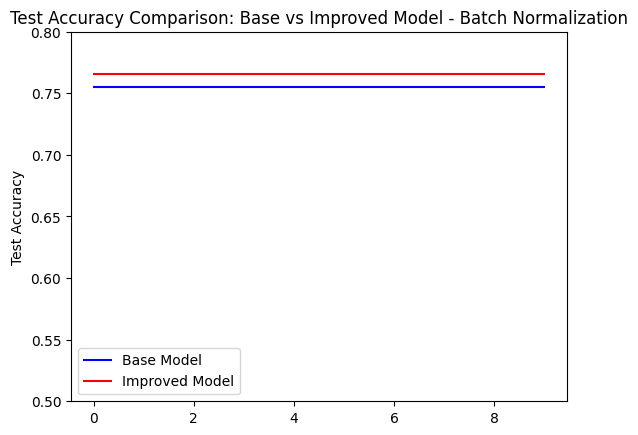

In [204]:
testingAccuracyLineCompare = [testingAccuracy] * 10
testingAccuracyLineBestModelCompare = [testingAccuracyBestModel] * 10
plt.plot(range(10), testingAccuracyLineCompare, label='Base Model', color='blue')
plt.plot(range(10), testingAccuracyLineBestModelCompare, label='Improved Model', color='red')
plt.ylabel('Test Accuracy')
plt.ylim(0.5, 0.8)
plt.title('Test Accuracy Comparison: Base vs Improved Model - Batch Normalization')
plt.legend()
plt.show()

